In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Oct_weekday_PM.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 901.158723
  (4,4) => 0.0
  (3,1) => 381.558578
  (4,5) => 324.6168
  (2,4) => 374.558563
  (6,5) => 622.597822
  (8,4) => 418.234851
  (1,2) => 534.318011
  (5,1) => 490.800689
  (3,4) => 727.671509
  (8,2) => 293.029808
  (2,3) => 400.606287
  (2,6) => 676.724031
  (5,4) => 506.739549
  (2,1) => 366.115468
  (2,5) => 575.625611
  (8,5) => 508.941142
  (1,4) => 544.569589
  (2,8) => 282.326284
  (5,8) => 301.475463
  (4,8) => 134.598718
  (7,8) => 219.054174
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 723.089104
  ⋮     => ⋮

In [11]:
using JSON

link_day_minute_Oct_dict = readall("../temp_files/link_day_minute_Oct_dict_JSON_adjusted.json");
link_day_minute_Oct_dict = replace(link_day_minute_Oct_dict, "NaN", 0);

link_day_minute_Oct_dict = JSON.parse(link_day_minute_Oct_dict);

In [12]:
# week_day_Oct_list = [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 29, 30, 31]

# training set 1
week_day_Oct_list_1 = [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19]

# training set 2
week_day_Oct_list_2 = [1, 2, 3, 4, 5, 8, 9, 22, 23, 24, 25, 26, 29, 30, 31]

# training set 3
week_day_Oct_list_3 = [11, 12, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 29, 30, 31]


arcs_1 = Dict{(Int, Int), Arc}[]
for j in week_day_Oct_list_1
    arcs_1_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Oct_dict[key]["init_node"]
        termNode = link_day_minute_Oct_dict[key]["term_node"]
        capacity = link_day_minute_Oct_dict[key]["PM_capac"]
        freeflowtime = link_day_minute_Oct_dict[key]["free_flow_time"]
        flow = link_day_minute_Oct_dict[key]["PM_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict{(Int, Int), Arc}[]
for j in week_day_Oct_list_2
    arcs_2_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Oct_dict[key]["init_node"]
        termNode = link_day_minute_Oct_dict[key]["term_node"]
        capacity = link_day_minute_Oct_dict[key]["PM_capac"]
        freeflowtime = link_day_minute_Oct_dict[key]["free_flow_time"]
        flow = link_day_minute_Oct_dict[key]["PM_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict{(Int, Int), Arc}[]
for j in week_day_Oct_list_3
    arcs_3_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Oct_dict[key]["init_node"]
        termNode = link_day_minute_Oct_dict[key]["term_node"]
        capacity = link_day_minute_Oct_dict[key]["PM_capac"]
        freeflowtime = link_day_minute_Oct_dict[key]["free_flow_time"]
        flow = link_day_minute_Oct_dict[key]["PM_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [13]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)
flow_data_2 = Array(Float64, length(arcs_2[1]), numData)
flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [14]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [901.158723,901.158723,901.158723,901.158723,901.158723,901.158723,9…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [381.558578,381.558578,381.558578,381.558578,381.558578,381.558578,3…
  (4,5) => [324.6168,324.6168,324.6168,324.6168,324.6168,324.6168,324.6168,324.…
  (2,4) => [374.558563,374.558563,374.558563,374.558563,374.558563,374.558563,3…
  (6,5) => [622.597822,622.597822,622.597822,622.597822,622.597822,622.597822,6…
  (8,4) => [418.234851,418.234851,418.234851,418.234851,418.234851,418.234851,4…
  (1,2) => [534.318011,534.318011,534.318011,534.318011,534.318011,534.318011,5…
  (5,1) => [490.800689,490.800689,490.800689,490.800689,490.800689,490.800689,4…
  (3,4) => [727.671509,727.671509,727.671509,727.671509,727.671509,727.671509,7…
  (8,2) => [293.029808,293.029808,293.029808,293.029808,293.029808,293.029808,2…
  (2,3) => [400.606287,400.606287,400.606287,400.606287,400.606

In [15]:
flow_data_3

24x15 Array{Float64,2}:
 3160.42  4354.99  2547.49   2829.02  …  3685.89   2654.78  4436.63  3978.41
 1896.13  4075.79  2448.5    2127.84     3656.6    2376.87  3516.76  2118.0 
 3117.16  4135.21  1278.8    1167.68     3839.29   1279.05  3465.61  3455.54
 1727.06  2973.76  1353.28   1346.37     1517.25   1332.86  1473.17  1461.14
 1434.85  2999.7   2069.98   1620.61     1222.51   2120.03  2542.42  1640.08
 4378.73  5075.68  2345.12   2466.58  …  4014.46   2747.68  4939.34  5436.88
 2553.19  3106.54  2386.26   1801.07     2400.41   2618.04  1906.49  2742.34
 2366.85  3297.06  2314.25   1796.69     1952.38   2783.71  2393.23  2336.42
 3678.79  4964.36   989.315  1308.16     4306.53   1415.11  3900.71  3507.58
 1453.78  2587.14  2251.25   1415.58      709.442  1912.91  1045.26  1143.08
 4229.72  4920.87  2439.88   2104.81  …  4251.97   2071.56  3704.41  3526.95
 1667.46  2198.08  1977.03   1629.76      769.507  1600.88  1232.6   1191.32
 2787.72  5235.26  2080.54   1972.24     4479.63   2

In [16]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [17]:
#include("trafficCval.jl")

coeffs_dict_Oct_PM = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [4:8]
c_grid = .5:.5:3.
lamb_grid = [10. .^(-3:4)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Oct_PM[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Oct_PM[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Oct_PM[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [18]:
outfile = open("../temp_files/coeffs_dict_Oct_PM.json", "w")

JSON.print(outfile, coeffs_dict_Oct_PM)

close(outfile)

In [19]:
coeffs_dict_Oct_PM_ = readall("../temp_files/coeffs_dict_Oct_PM.json")
coeffs_dict_Oct_PM_ = JSON.parse(coeffs_dict_Oct_PM_)

Dict{UTF8String,Any} with 720 entries:
  "(7,2.5,10000.0,3)" => {1.0,0.02051104679705385,0.012760907689854438,0.0049190…
  "(5,0.5,100.0,3)"   => {1.0,0.008650756292494429,0.020645383415849348,0.019446…
  "(6,1.5,10.0,3)"    => {1.0,0.021441804316953014,0.01202744391761069,0.0036635…
  "(6,2.0,0.1,2)"     => {1.0,0.023570942517547606,-0.05084627264906751,0.026087…
  "(4,0.5,1000.0,1)"  => {1.0,0.011675051972971487,0.018026454740864256,0.012620…
  "(6,2.0,0.01,1)"    => {1.0,0.07900692061881708,-0.2020183378886398,0.20903820…
  "(8,1.5,0.01,1)"    => {1.0,0.09130140296274969,-0.2723477411486753,0.27875425…
  "(5,1.5,1.0,1)"     => {1.0,0.03273576487582188,-0.010271854737189839,-0.00907…
  "(8,2.5,0.001,2)"   => {1.0,0.041171606823884065,-0.18799018593218697,0.389242…
  "(4,2.0,0.1,1)"     => {1.0,0.04628531360360332,-0.052468540880675416,0.013887…
  "(5,1.0,1000.0,2)"  => {1.0,0.006627005764042347,0.005167385094408513,0.001910…
  "(4,2.0,0.1,2)"     => {1.0,0.015577351376647074,-0.01663

In [20]:
coeffs_dict_Oct_PM_["(8,0.5,10000.0,1)"]

9-element Array{Any,1}:
  1.0       
 -0.00266084
  0.0581286 
 -0.19636   
  0.617784  
 -0.910203  
  0.932352  
 -0.470717  
  0.108244  

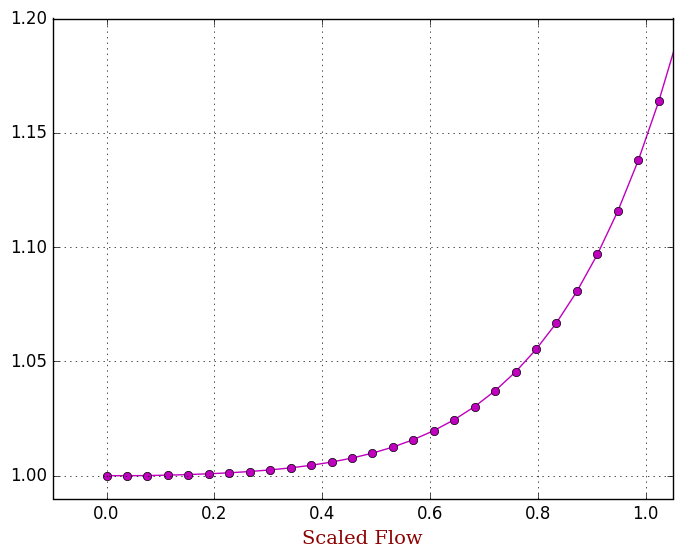

In [24]:
using PyPlot

fcoeffs = coeffs_dict_Oct_PM_["(8,0.5,1000.0,3)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Oct_PM")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.05);
ylim(0.99, 1.2);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Oct_PM.pdf")